# Loading data and augmentations - Section 1 & 3

In [1]:
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os
import random

class PlotDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = os.listdir(os.path.join(folder_path, "Images"))
        self.mask_files = os.listdir(os.path.join(folder_path, "Masks"))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, "Images", self.image_files[idx])
        mask_name = os.path.join(self.folder_path, "Masks", self.mask_files[idx])

        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask




data_folder ="./Data"
plot_dataset = PlotDataset(data_folder, transform=None)
batch_size = 4

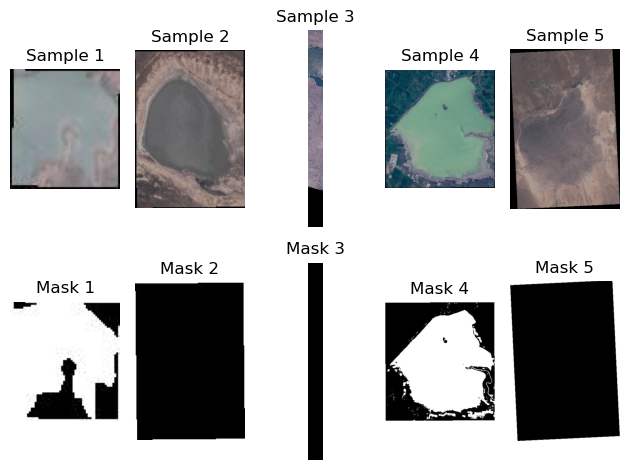

In [2]:
import matplotlib.pyplot as plt
import random


num_samples_to_display = 5
fig, (ax1, ax2) = plt.subplots(2, num_samples_to_display)


random_indices = random.sample(range(len(plot_dataset)), num_samples_to_display)

for i, idx in enumerate(random_indices):
    image, mask = plot_dataset[idx]

    # Plot image
    ax1[i].imshow(image)
    ax1[i].axis('off')
    ax1[i].set_title(f"Sample {i + 1}")

    # Plot mask
    ax2[i].imshow(mask, cmap='gray')
    ax2[i].axis('off')
    ax2[i].set_title(f"Mask {i + 1}")

plt.tight_layout()
plt.show()


In [3]:
import numpy as np
def get_bounding_box(ground_truth_map):
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  H, W = ground_truth_map.shape
  x_min = max(0, x_min)
  x_max = min(W, x_max)
  y_min = max(0, y_min)
  y_max = min(H, y_max)
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [4]:
import albumentations as A
import albumentations.pytorch

In [5]:
import numpy as np
from torch.utils.data import Dataset
class SAMDataset(Dataset):
    def __init__(self, folder_path, processor=None):
        self.folder_path = folder_path
        self.image_files = os.listdir(os.path.join(folder_path, "Images"))
        self.mask_files = os.listdir(os.path.join(folder_path, "Masks"))
        self.processor = processor




        self.mask_transform = A.Compose([
            A.Resize(256, 256),
            A.Normalize(mean=(0.0),std=(1.0),max_pixel_value=255.0)])
        self.to_tensor = A.Compose([albumentations.pytorch.transforms.ToTensorV2()])
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, "Images", self.image_files[idx])
        mask_name = os.path.join(self.folder_path, "Masks", self.mask_files[idx])
        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name).convert("L")

        # Augmention
        crop_height = int(image.size[1] * (10/ 100))
        crop_width = int(image.size[0] * (10 / 100))
        height_diff = image.size[1] - crop_height
        width_diff = image.size[0] - crop_width
        
        transforms = A.Compose([
            A.CenterCrop(p=1, height=height_diff, width=width_diff),
            A.HueSaturationValue(p=0.5),
            A.RandomBrightnessContrast(p=0.5)
        ])
        
        transformed = transforms(image=np.array(image), mask=np.array(mask))
        image = transformed['image']
        mask = transformed['mask']



        # prompting 
        if np.all(mask == 0):
            prompt = [0 , 0 ,image.shape[0],image.shape[1]]
        else:
            prompt = get_bounding_box(np.array(mask))
        
        tensors = self.to_tensor(image=np.array(image), mask=np.array(mask))
        mask_transformed = self.mask_transform( image=np.array(tensors['mask']))['image']
        inputs = self.processor(tensors['image'], input_boxes=[[prompt]], return_tensors="pt")
        inputs = {k:v.squeeze(0).to("cuda") for k,v in inputs.items()}



        return inputs, mask_transformed, img_name



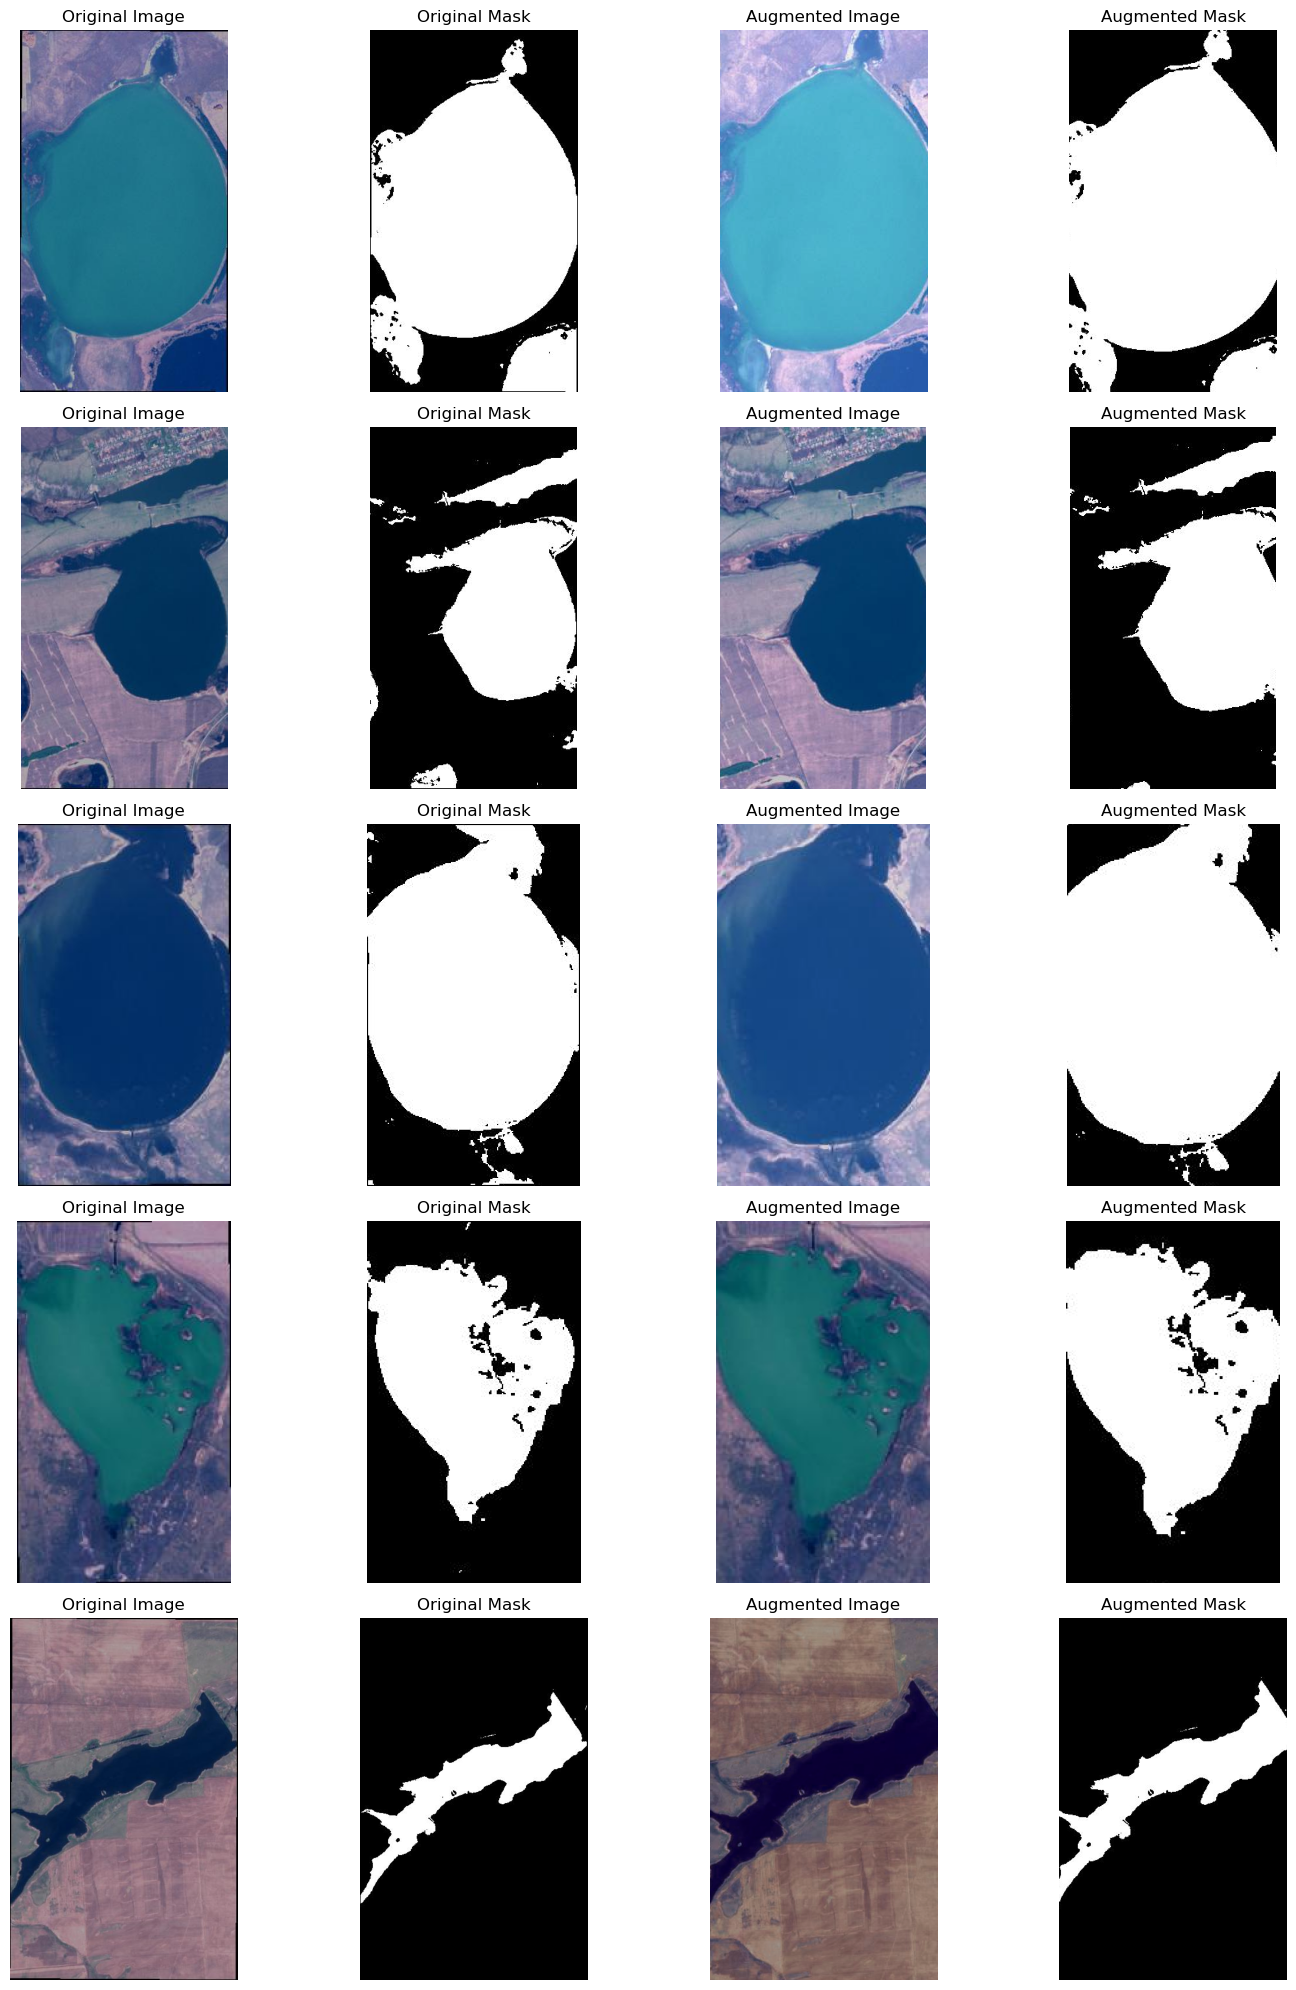

In [6]:
data_folder = "./Data"
image_files = os.listdir(os.path.join(data_folder, "Images"))
mask_files = os.listdir(os.path.join(data_folder, "Masks"))

# Choose 5 images from the directory
fig, axs = plt.subplots(5, 4, figsize=(15, 20))
selected_images = image_files[10:15]
row = 0
for img_name in selected_images:
    
    image_path = os.path.join(data_folder, "Images", img_name)
    mask_name = img_name  # Adjust mask naming convention as needed
    mask_path = os.path.join(data_folder, "Masks", mask_name)
    
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")
    
    crop_height = int(image.size[1] * (10/ 100))
    crop_width = int(image.size[0] * (10 / 100))
    height_diff = image.size[1] - crop_height
    width_diff = image.size[0] - crop_width
    
    transforms = A.Compose([
        A.CenterCrop(p=1, height=height_diff, width=width_diff),
        A.HueSaturationValue(p=0.5),
        A.RandomBrightnessContrast(p=0.5)
    ])
    
    transformed = transforms(image=np.array(image), mask=np.array(mask))
    augmented_image = transformed['image']
    augmented_mask = transformed['mask']

    # Original Image
    axs[row, 0].imshow(np.array(image))
    axs[row, 0].set_title("Original Image")
    axs[row, 0].axis('off')

    # Original Mask
    axs[row, 1].imshow(np.array(mask), cmap='gray')
    axs[row, 1].set_title("Original Mask")
    axs[row, 1].axis('off')

    # Augmented Image
    axs[row, 2].imshow(augmented_image)
    axs[row, 2].set_title("Augmented Image")
    axs[row, 2].axis('off')

    # Augmented Mask
    axs[row, 3].imshow(augmented_mask, cmap='gray')
    axs[row, 3].set_title("Augmented Mask")
    axs[row, 3].axis('off')
    row = row + 1

plt.tight_layout()
plt.show()

In [7]:

from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
sam_dataset = SAMDataset(folder_path=data_folder, processor=processor)


In [8]:
from torch.utils.data import Subset, DataLoader, random_split
import numpy as np



dataset_size = len(sam_dataset)
train_size = int(0.9 * dataset_size)
val_size = dataset_size - train_size

indices = list(range(dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[:train_size], indices[train_size:]

train_dataset = Subset(sam_dataset, train_indices)
val_dataset = Subset(sam_dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True)


# Load Sam - Section 2

In [9]:

from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)


In [10]:
from re import X
from torch import nn
class SAM(nn.Module):
    def __init__(self,model_base):
      super(SAM,self).__init__()
      self.model_base = model_base
      self.norm = nn.BatchNorm2d(1)
      self.sig = nn.Sigmoid()
    def forward(self, x):
      out_base = self.model_base(**x)
      index = torch.argmax(out_base.iou_scores, dim=2)
      x = out_base.pred_masks.squeeze(1)
      result = ()
      for i in range(0,x.shape[0]):
          result = result + (x[i,index[i][0].item(),:,:].unsqueeze(0),)

      x = torch.cat(result, dim=0)

      x = self.norm(x.unsqueeze(1)).squeeze(1)
      x = self.sig(x)

      return x

model_sam = SAM(model)

# Metrics, Optimizer, Cost function - Section 4

In [11]:
import numpy as np

def dice_coefficient(prediction, target):
    prediction = prediction.flatten()
    target = target.flatten()

    intersection = np.sum(prediction * target)
    dice = (2. * intersection) / (np.sum(prediction) + np.sum(target))

    return dice

def iou_score(prediction, target):
    intersection = np.sum(prediction * target)
    union = np.sum(prediction) + np.sum(target)

    iou = intersection / (union + 1e-8)  # Adding a small value to prevent division by zero

    return iou



In [12]:
from torch.optim import AdamW

optim = AdamW(model_sam.parameters(), lr=1e-3)
seg_loss = torch.nn.BCELoss()


# Fine-Tuning

In [13]:
import numpy as np
import torch
from tqdm import tqdm

num_epochs = 15

device = "cuda" if torch.cuda.is_available() else "cpu"
model_sam.to(device)
train_results = {"loss":[], "iou":[],"dice":[]}
validation_results = {"loss":[], "iou":[],"dice":[]}

for epoch in range(1, num_epochs):
    epoch_losses = []
    epoch_dice = []
    epoch_iou = []
    model_sam.train()
    for batch, mask, image in tqdm(train_dataloader):
        outputs = model_sam(batch)

        predicted_masks = outputs.to(device)
        ground_truth_masks = mask.float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks)

        predicted_masks = (predicted_masks >= 0.5).float()
        ground_truth_masks = (ground_truth_masks >= 0.5).float()

        dice = dice_coefficient(predicted_masks.flatten().cpu().detach().numpy() ,
                                ground_truth_masks.flatten().cpu().detach().numpy() )
        iou = iou_score(predicted_masks.flatten().cpu().detach().numpy() ,
                        ground_truth_masks.flatten().cpu().detach().numpy() )

        epoch_losses.append(loss.item())
        epoch_dice.append(dice)
        epoch_iou.append(iou)

        optim.zero_grad()
        loss.backward()
        optim.step()

    model_sam.eval()
    validation_losses = []
    validation_dice = []
    validation_iou = []

    with torch.no_grad():
        for batch, mask, image in tqdm(valid_dataloader):
            predicted_masks = model_sam(batch)
            ground_truth_masks = mask.float().to(device)

            loss = seg_loss(predicted_masks.to(device), ground_truth_masks)

            predicted_masks = (predicted_masks >= 0.5).float()
            ground_truth_masks = (ground_truth_masks >= 0.5).float()

            dice = dice_coefficient(predicted_masks.flatten().cpu().detach().numpy() ,
                                    ground_truth_masks.flatten().cpu().detach().numpy() )
            iou = iou_score(predicted_masks.flatten().cpu().detach().numpy() ,
                            ground_truth_masks.flatten().cpu().detach().numpy() )

            validation_losses.append(loss.item())
            validation_dice.append(dice)
            validation_iou.append(iou)

    print(f'EPOCH: {epoch}')
    print(f'Train loss: {np.mean(epoch_losses)}')
    print(f'Validation Loss: {np.mean(validation_losses)}')
    print(f'Train Dice Coefficient: {np.mean(epoch_dice)}')
    print(f'Validation Dice Coefficient: {np.mean(validation_dice)}')
    print(f'Train IoU: {np.mean(epoch_iou)}')
    print(f'Validation IoU: {np.mean(validation_iou)}')
    
    train_results["loss"].append(np.mean(epoch_losses))
    train_results["dice"].append(np.mean(epoch_dice))
    train_results["iou"].append(np.mean(epoch_iou))

    validation_results["loss"].append(np.mean(validation_losses))
    validation_results["dice"].append(np.mean(validation_dice))
    validation_results["iou"].append(np.mean(validation_iou))



100%|██████████| 143/143 [00:47<00:00,  2.98it/s]


EPOCH: 1
Train loss: 0.5450468633982684
Validation Loss: 0.9975977410542798
Train Dice Coefficient: 0.6117384327016313
Validation Dice Coefficient: 0.0
Train IoU: 0.30586921635078074
Validation IoU: 0.0


100%|██████████| 143/143 [00:47<00:00,  2.98it/s]


EPOCH: 2
Train loss: 0.4998965557891998
Validation Loss: 0.4709871068492636
Train Dice Coefficient: 0.6236941674520612
Validation Dice Coefficient: 0.5923091138723031
Train IoU: 0.31184708372599096
Validation IoU: 0.2961545569361115


100%|██████████| 143/143 [00:48<00:00,  2.97it/s]


EPOCH: 3
Train loss: 0.48332913647841586
Validation Loss: 0.42252008783650563
Train Dice Coefficient: 0.6400968152317542
Validation Dice Coefficient: 0.5552671695797831
Train IoU: 0.32004840761583503
Validation IoU: 0.2776335847898387


100%|██████████| 143/143 [00:48<00:00,  2.96it/s]


EPOCH: 4
Train loss: 0.4723467708963184
Validation Loss: 0.4524196546811324
Train Dice Coefficient: 0.6476746149344272
Validation Dice Coefficient: 0.6340018207402537
Train IoU: 0.32383730746717154
Validation IoU: 0.317000910370082


100%|██████████| 143/143 [00:48<00:00,  2.96it/s]


EPOCH: 5
Train loss: 0.460372517249767
Validation Loss: 0.4188116128211255
Train Dice Coefficient: 0.6621220660996016
Validation Dice Coefficient: 0.5788449385589163
Train IoU: 0.33106103304975754
Validation IoU: 0.2894224692794105


100%|██████████| 143/143 [00:48<00:00,  2.96it/s]


EPOCH: 6
Train loss: 0.4551246390446251
Validation Loss: 0.4181136954706032
Train Dice Coefficient: 0.6670629233389269
Validation Dice Coefficient: 0.6446416092268431
Train IoU: 0.3335314616694198
Validation IoU: 0.322320804613376


100%|██████████| 143/143 [00:48<00:00,  2.97it/s]


EPOCH: 7
Train loss: 0.45033244463339656
Validation Loss: 0.4072222469465716
Train Dice Coefficient: 0.6691940165009469
Validation Dice Coefficient: 0.5760114999959096
Train IoU: 0.3345970082504296
Validation IoU: 0.2880057499979068


100%|██████████| 143/143 [00:48<00:00,  2.97it/s]


EPOCH: 8
Train loss: 0.4423222414717801
Validation Loss: 0.4119309594372769
Train Dice Coefficient: 0.6822464354685238
Validation Dice Coefficient: 0.6172693086250167
Train IoU: 0.3411232177342174
Validation IoU: 0.3086346543124652


100%|██████████| 143/143 [00:48<00:00,  2.97it/s]


EPOCH: 9
Train loss: 0.44565345028616454
Validation Loss: 0.40784357769505963
Train Dice Coefficient: 0.6767241592682782
Validation Dice Coefficient: 0.663641929359674
Train IoU: 0.33836207963409454
Validation IoU: 0.3318209646797836


100%|██████████| 143/143 [00:48<00:00,  2.97it/s]


EPOCH: 10
Train loss: 0.4387999302554578
Validation Loss: 0.4094431608706921
Train Dice Coefficient: 0.6861834294411023
Validation Dice Coefficient: 0.6184478541952628
Train IoU: 0.3430917147205058
Validation IoU: 0.3092239270975836


100%|██████████| 143/143 [00:48<00:00,  2.98it/s]


EPOCH: 11
Train loss: 0.44501302359809336
Validation Loss: 0.39606931295011427
Train Dice Coefficient: 0.6811816720032178
Validation Dice Coefficient: 0.6400997082457822
Train IoU: 0.34059083600156437
Validation IoU: 0.3200498541228407


100%|██████████| 143/143 [00:48<00:00,  2.97it/s]


EPOCH: 12
Train loss: 0.43517261577977073
Validation Loss: 0.39908431939311795
Train Dice Coefficient: 0.6872628143137325
Validation Dice Coefficient: 0.6341417913568328
Train IoU: 0.3436314071568209
Validation IoU: 0.31707089567836555


100%|██████████| 143/143 [00:49<00:00,  2.88it/s]


EPOCH: 13
Train loss: 0.43255380685667105
Validation Loss: 0.39097155135619893
Train Dice Coefficient: 0.6919786748071076
Validation Dice Coefficient: 0.6370287043007515
Train IoU: 0.3459893374035079
Validation IoU: 0.3185143521503222


100%|██████████| 143/143 [00:48<00:00,  2.96it/s]

EPOCH: 14
Train loss: 0.4336612834850201
Validation Loss: 0.4274316814604339
Train Dice Coefficient: 0.68854446847527
Validation Dice Coefficient: 0.5618380422004365
Train IoU: 0.3442722342375892
Validation IoU: 0.2809190211001732


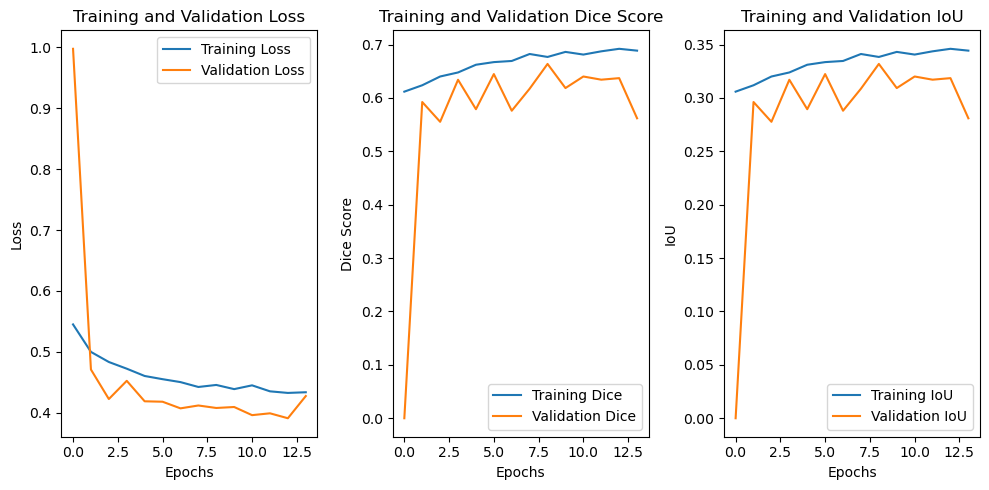

In [14]:
import matplotlib.pyplot as plt

epochs = len(train_results['loss'])

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.plot(range(epochs), train_results['loss'], label='Training Loss')
plt.plot(range(epochs), validation_results['loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(epochs), train_results['dice'], label='Training Dice')
plt.plot(range(epochs), validation_results['dice'], label='Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.title('Training and Validation Dice Score')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(epochs), train_results['iou'], label='Training IoU')
plt.plot(range(epochs), validation_results['iou'], label='Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Training and Validation IoU')
plt.legend()

plt.tight_layout()
plt.show()


# Feed-forward

In [15]:
from matplotlib.patches import Rectangle


def show_mask_with_rectangle(image, ax, bounding_box=None):
    h, w = image.shape[-2:]
    image = image
    ax.imshow(image)
    if bounding_box is not None:
        x_min, y_min, x_max, y_max = bounding_box

        rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                         linewidth=2, edgecolor='red', facecolor='none')

        ax.add_patch(rect)


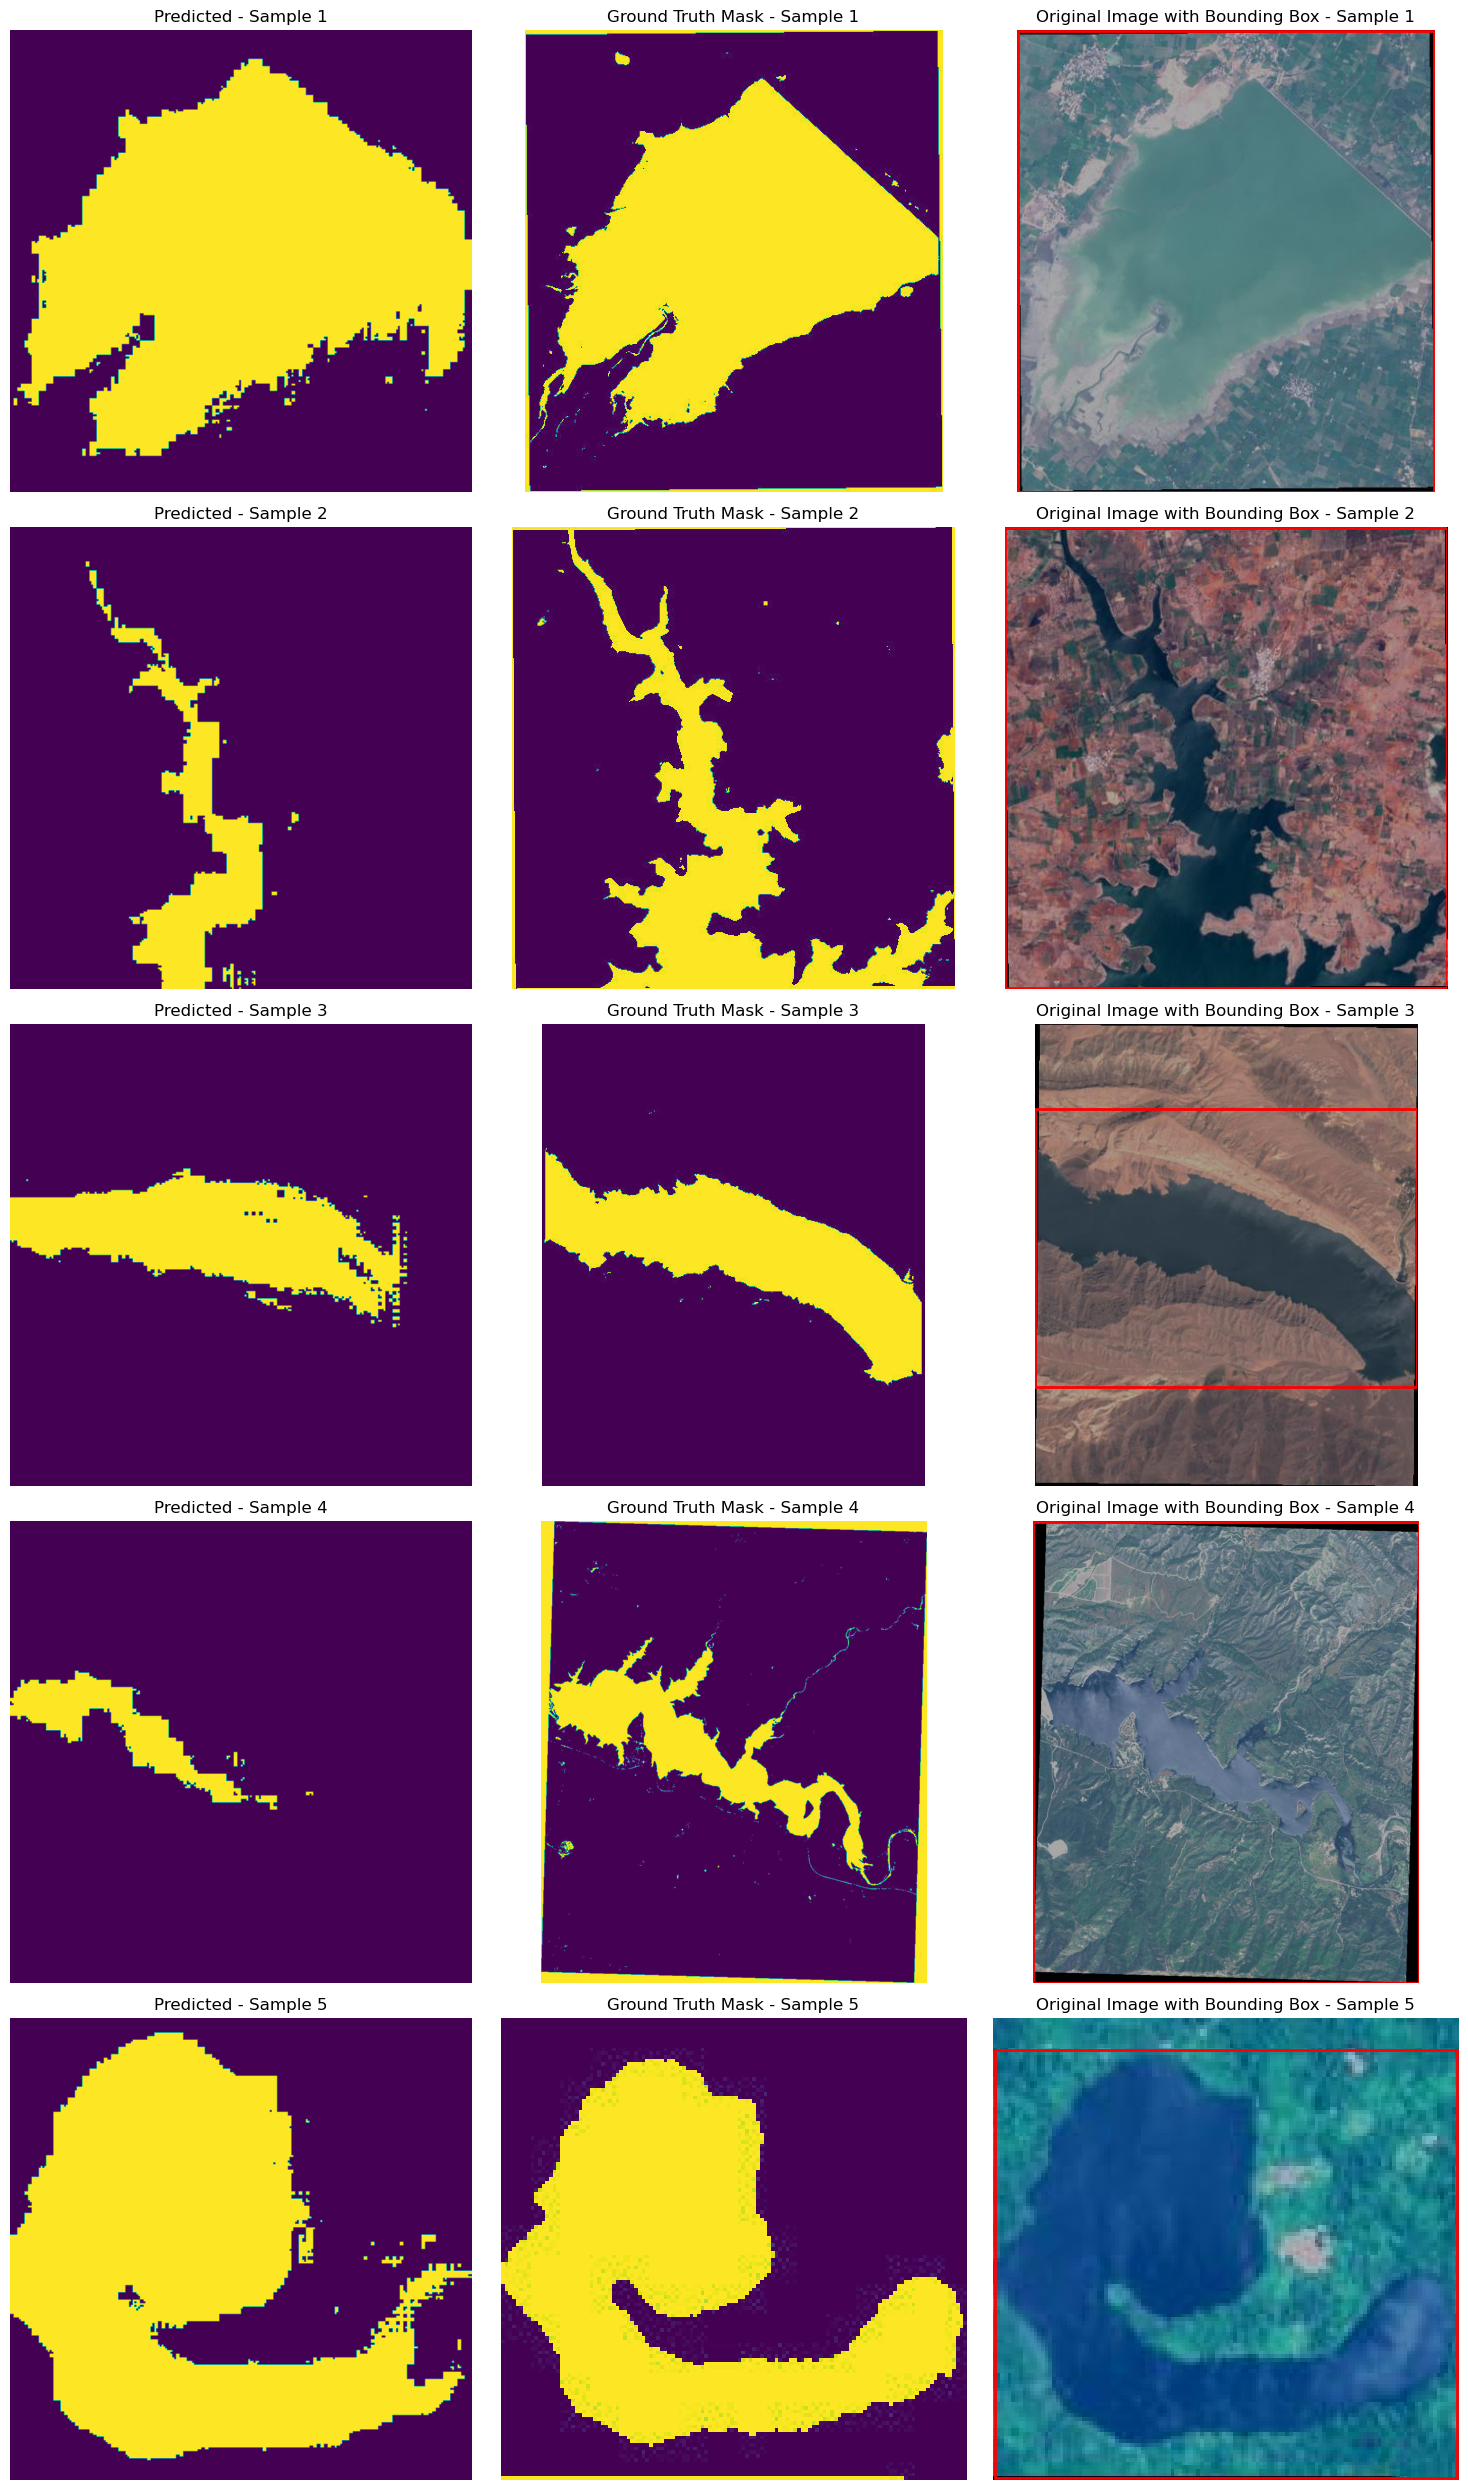

In [23]:
import matplotlib.pyplot as plt

num_samples = 5
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

for i in range(num_samples):
    data_iter = iter(valid_dataloader)
    batch, _, address = next(data_iter)
    
    image = Image.open(address[0]).convert("RGB")
    mask = Image.open(address[0].replace("Images", "Masks")).convert("L")
    prompt = get_bounding_box(np.array(mask))
    
    model.to("cuda")
    model.eval()
    with torch.no_grad():
        outputs = model_sam(batch)[0]
    
    medsam_seg = (outputs.cpu().numpy().squeeze() > 0.5).astype(np.uint8)
    
    axes[i, 0].imshow(medsam_seg)
    axes[i, 0].set_title(f'Predicted - Sample {i+1}')
    axes[i, 0].axis("off")
    
    axes[i, 1].imshow(mask, cmap='viridis')
    axes[i, 1].set_title(f'Ground Truth Mask - Sample {i+1}')
    axes[i, 1].axis("off")
    
    show_mask_with_rectangle(np.array(image), axes[i, 2], bounding_box=prompt)
    axes[i, 2].set_title(f'Original Image with Bounding Box - Sample {i+1}')
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


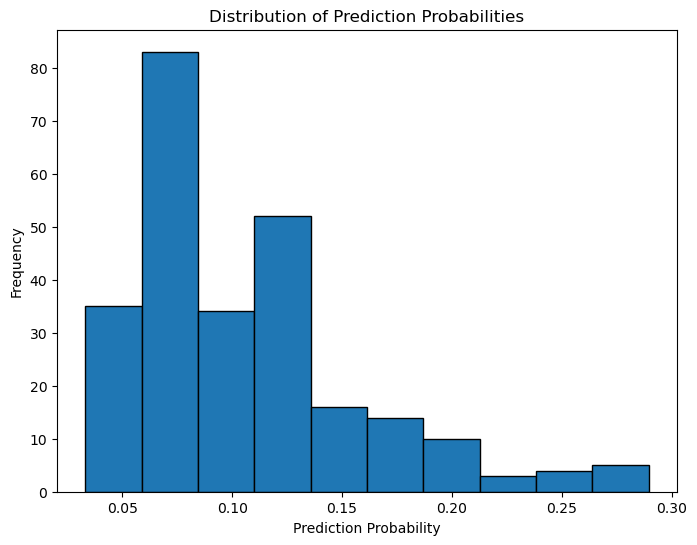

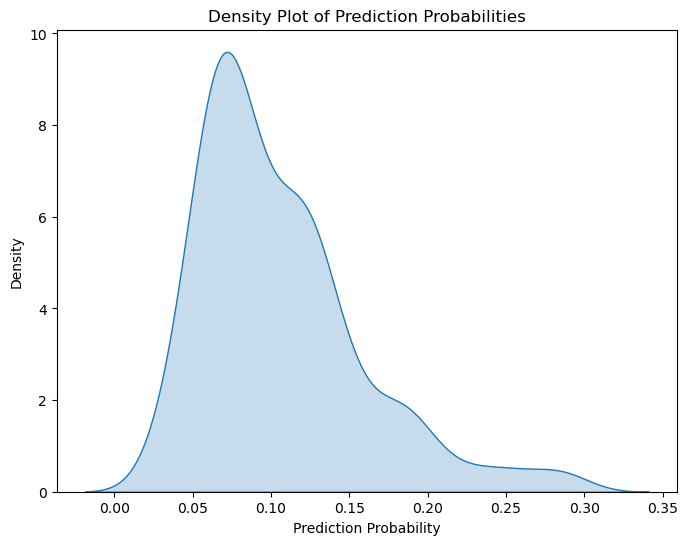

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

prediction_probabilities = outputs[0].cpu().numpy().squeeze()
predictions = prediction_probabilities.tolist()


plt.figure(figsize=(8, 6))
plt.hist(predictions, bins=10, edgecolor='black')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Probabilities')
plt.show()

plt.figure(figsize=(8, 6))
sns.kdeplot(predictions, shade=True)
plt.xlabel('Prediction Probability')
plt.ylabel('Density')
plt.title('Density Plot of Prediction Probabilities')
plt.show()


In [29]:
print(type(outputs[0]))

<class 'torch.Tensor'>
